In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cartpole_lib_python import *
import odrive

In [2]:
init_odrive()

axis0
  active_errors: no error
  disarm_reason: no error
  procedure_result: ProcedureResult.SUCCESS
  last_drv_fault: none
internal issues: none
axis0
  active_errors: no error
  disarm_reason: no error
  procedure_result: ProcedureResult.CANCELLED
  last_drv_fault: none
internal issues: none
odrive initialized


In [3]:
odrv = get_odrive()
odrive.utils.dump_errors(odrv)

axis0
  active_errors: no error
  disarm_reason: no error
  procedure_result: ProcedureResult.CANCELLED
  last_drv_fault: none
internal issues: none


In [107]:
print(get_state())

[-0.06553396022613647, -6.139758103512683, -0.00040687321675797873, -0.015030671330329277]


In [5]:
-6.099874603027654+np.pi

-2.958281949437861

In [410]:
angles = []

In [715]:
xg = np.array([-0.01647457, -2.958281949437861, 0, 0])
measurement = get_measurement() - xg[:2]
print(measurement)
angles.append(measurement[1])

[0.00489647 0.0322136 ]


In [718]:
control_frequency = 300 # Hz
control_period = 1/control_frequency
h = control_period
T = 3 # runtime, seconds
N = int(T*control_frequency)
print("N: ", N)

# 60 hz

div = 1.3
k_mult = 0.2

# Long pole
k_matrix = np.array([-3.07087, -10.60030, -2.87162, -1.82652/div]) * k_mult
A = np.array([[1.0000000000, -0.0000181682, 0.0033333333, -0.0000000202/div],
              [0.0000000000, 1.0005141950, 0.0000000000, 0.0033339046/div],
              [0.0000000000, -0.0109018681, 1.0000000000, -0.0000181682/div],
              [0.0000000000, 0.3085434363, 0.0000000000, 1.0005141950/div]])   
B = np.array([[0.00016],
              [-0.0011647865],
              [0.0987696638],
              [-0.6989317845]])

H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

meas_noise_cov = np.diag([.1, .1]) # most recent
process_noise_cov = np.diag([1, 1, 50, 50]) # position, angle, linear velocity, angular velocity

nx = process_noise_cov.shape[0]
def kf_update(x_meas, x_pred_prev, est_cov_prev):
    Kn = est_cov_prev@H.T @ np.linalg.inv(H@est_cov_prev@H.T + meas_noise_cov)
    x = x_pred_prev + Kn @ (x_meas - H@x_pred_prev)
    est_cov = (np.eye(nx) - Kn@H) @ est_cov_prev @ (np.eye(nx) - Kn@H).T + Kn@meas_noise_cov@Kn.T
    return x, est_cov

def kf_predict(state, control, est_cov):
    x_pred = A@state + B@control
    est_cov_pred = A@est_cov@A.T + process_noise_cov
    return x_pred, est_cov_pred

# Initialize Kalman filter variables
# First state estimate
meas = get_measurement() - xg[:2]
x = np.array([meas[0], meas[1], 0, 0])
x_pred_prev = x
# Estimation covariance
est_cov = np.eye(4)*20
est_cov_prev = est_cov

xs = np.zeros(np.append(x.shape, N))
measurements = np.zeros((2,N))
controls = np.zeros(N)
control_clamp = .2

measure_times = []
control_times = []
command_times = []
loop_times = []

for i in range(N):
    time_start = time.perf_counter()
    
    measurement = get_measurement() - xg[:2]
    measure_times.append(time.perf_counter() - time_start)
    if i > 0:
        x, est_cov = kf_update(measurement, x_pred_prev, est_cov_prev)
    
    # x[3] /= 2.0
    xs[:,i] = x
    measurements[:,i] = measurement
    control = -k_matrix @ x
    control = min(control_clamp, max(-control_clamp, control))
    
    control_times.append(time.perf_counter() - time_start)
    
    x_pred_prev, est_cov_prev = kf_predict(x, [control], est_cov)
    
    command_linear_torque(-control)
    # command_linear_torque(0)
    controls[i] = control
    
    if measurement[0] < -0.09 or measurement[0] > 0.09:
        break
    if measurement[1] < -0.5 or measurement[0] > 0.5:
        break
    
    command_times.append(time.perf_counter() - time_start)
    busy_sleep(control_period, time_start, get_now=time.perf_counter)
    loop_times.append(time.perf_counter() - time_start)


command_linear_torque(0)

N:  900


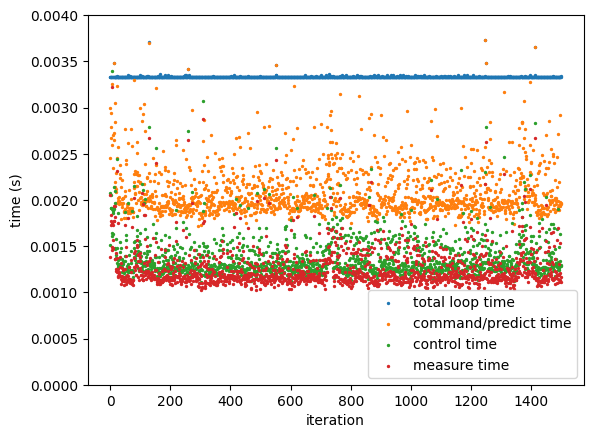

In [693]:
plt.scatter(range(len(loop_times)), np.array(loop_times), s=2, label="total loop time")
plt.scatter(range(len(loop_times)), np.array(command_times), s=2, label="command/predict time")
plt.scatter(range(len(loop_times)), np.array(control_times), s=2, label="control time")
plt.scatter(range(len(loop_times)), np.array(measure_times), s=2, label="measure time")

plt.ylim([0,.004])
plt.legend()
plt.ylabel("time (s)")
plt.xlabel("iteration")

plt.show()

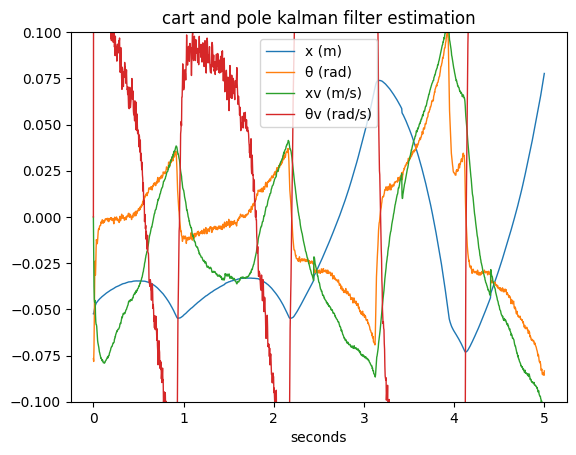

In [694]:
xs_plt = xs
plt.plot(np.linspace(0, len(measurements[0])/control_frequency, len(measurements[0])), xs.T, '-', linewidth=1)
plt.title('cart and pole kalman filter estimation')
plt.legend(['x (m)', 'θ (rad)', 'xv (m/s)', 'θv (rad/s)'])
plt.xlabel('seconds')
plt.ylim([-.1, .1])
plt.show()

Text(0.5, 1.0, 'control input')

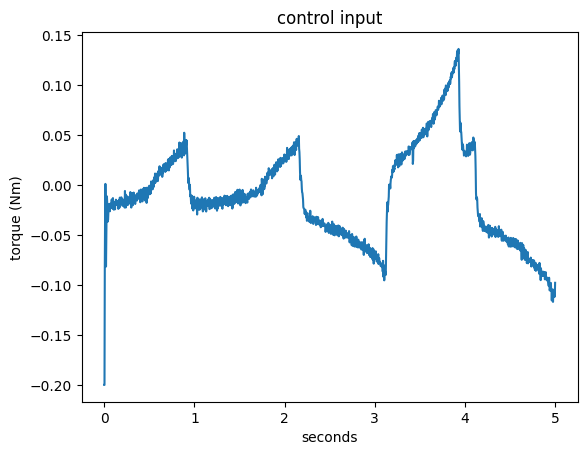

In [695]:
plt.plot(np.linspace(0, len(measurements[0])/control_frequency, len(measurements[0])), controls)
# plt.ylim([-.07, .07])
plt.ylabel('torque (Nm)')
plt.xlabel('seconds')
plt.title('control input')